In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,"/home/joep/Documents/Gits/thesis_hpc/lib")
import utils
import numpy as np
from models import lorentznetV2 as lorentznet
from models.feature_layers import AdjacencyMatrix
from models.CustomModels import SupervisedModel

In [2]:
config = utils.parse_config("config.py")
config["BATCH_SIZE"] = 16

Expanding key N_FEATURES


In [3]:
from keras import ops as ko
input_shapes = dict(coordinates=(config["N"],4), mask=(config["N"],1))
if(config["N_FEATURES"]!=0): #add scalar features
    input_shapes["scalars"] = (config["N"],config["N_FEATURES"]+(config.get("NOISE_FEATURES") or 0))
model = lorentznet.lorentz_net(input_shapes=input_shapes, ln_params=config["LN_PARAMS"],
            mlp_params=dict(phi_e=config["LN_PHI_E"], phi_x=config["LN_PHI_X"], phi_h=config["LN_PHI_H"], phi_m=config["LN_PHI_M"]),
            no_scalars=config["N_FEATURES"]==0, model_class=SupervisedModel, **config.get("MODEL_ARGS", {}))

LGEB input shapes: ((None, 4), None)


In [4]:
import main
main.config = config
main.setup_logging(config)
train_gen, val_gen = main.get_data(config)

2024-09-10 20:16:51,918 - main - WARNING - Failed to record Job ID
2024-09-10 20:16:51,920 - main - INFO - Using run ID 341
2024-09-10 20:16:51,921 - main - WARNING - Failed to record Job ID
2024-09-10 20:16:52,079 - main - DEBUG - Using validation split of 0.1
2024-09-10 20:16:52,080 - main - INFO - 	Data
		Background: 899997/999997
		Signal: 899995/999995
2024-09-10 20:16:52,080 - main - DEBUG - SEED: 10
2024-09-10 20:16:52,081 - main - WARNING - Using features: None
2024-09-10 20:16:52,081 - main - INFO - 112499 training steps and 12499 validation steps


899997 background and 899995 signal events passed the discriminator and/or slice
99999 background and 99999 signal events passed the discriminator and/or slice


2024-09-10 20:17:08,674 - main - DEBUG - Train generator: 112499
Val generator: 12499


In [5]:
x,y = train_gen[8]
print([xi.shape for xi in x],y.shape)
n_particles = np.sum(x[1], axis=(1,2))
print(n_particles[-10:])

[(16, 40, 4), (16, 40, 1)] (16, 2)
[40. 40. 40. 31. 40. 40. 40. 36. 31. 36.]


In [10]:
train_gen.labels.sum(axis=0)

array([899997, 899995])

: 

In [24]:
mask = ko.squeeze(ko.not_equal(x[1], 0),axis=2)
node_mask, edge_mask = mask, lorentznet.create_edge_mask(mask)
edges, seg_ids = AdjacencyMatrix(ko.shape(x[0])[1])(node_mask, edge_mask)

In [25]:
i,j = edges
seg_i, seg_j, idx_down, idx_up = seg_ids
print(i)
print(seg_i)
print(j)
print(seg_j)
print(idx_down)
print(idx_up)

tf.Tensor([  0   0   0 ... 635 635 635], shape=(22296,), dtype=int32)
tf.Tensor([  0   0   0 ... 635 635 639], shape=(22297,), dtype=int32)
tf.Tensor([  1   2   3 ... 632 633 634], shape=(22296,), dtype=int32)
tf.Tensor([  1   2   3 ... 633 634 639], shape=(22297,), dtype=int32)
tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174

In [26]:
coords = ko.reshape(x[0], (-1, *x[0].shape[2:]))
ko.take(ko.segment_sum(ko.take(coords,seg_j,axis=0), segment_ids=seg_i, num_segments=None, sorted=True), idx_down,axis=0)

<tf.Tensor: shape=(640, 4), dtype=float32, numpy=
array([[454.24045  , 441.1338   ,  10.560795 ,  12.786745 ],
       [454.24048  , 441.1338   ,  10.5608015,  12.786745 ],
       [542.2122   , 529.6648   ,  -4.958487 ,  19.783163 ],
       ...,
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ]],
      dtype=float32)>

In [27]:
model(x)

ResourceExhaustedError: Exception encountered when calling Dense.call().

[1m{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[22296,72] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul] name: [0m

Arguments received by Dense.call():
  • inputs=tf.Tensor(shape=(22296, 2), dtype=float32)
  • training=None

# Checking the data

In [16]:
import matplotlib.pyplot as plt
import h5py
from utils.coords import XYZ_to_PtEtaPhi
import numpy as np

file_bg = h5py.File("/hpcwork/kd106458/data/transformer/original_binned/qcd_test_nonan.h5", 'r')
file_sn = h5py.File("/hpcwork/kd106458/data/transformer/original_binned/top_test_nonan.h5", 'r')

bg_4mom = np.array(file_bg["4mom"][:10000])
sn_4mom = np.array(file_sn["4mom"][:10000])

bg_pt = np.array(file_bg["features"][:10000, :, 2:4])
sn_pt = np.array(file_sn["features"][:10000, :, 2:4])

bg_mask = np.array(file_bg["mask"][:10000,:,0], dtype=bool)
sn_mask = np.array(file_sn["mask"][:10000,:,0], dtype=bool)


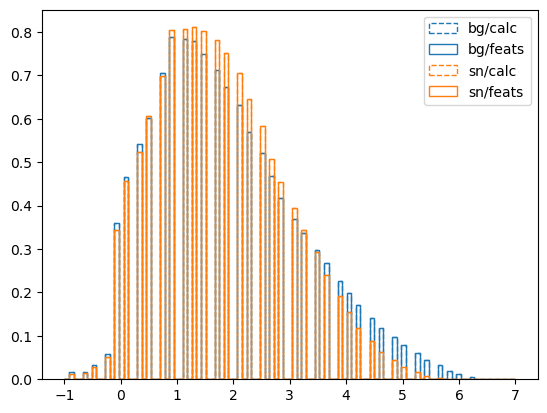

In [13]:
x = bg_4mom[bg_mask]
x_pt = bg_pt[:,:,0][bg_mask]
pt = np.sqrt(x[:,1]**2 + x[:,2]**2)
fig, ax = plt.subplots()
bins = np.linspace(-1, 7, 100)
ax.hist(np.log(1e-30+pt), bins=bins, histtype='step', color='C0', linestyle='--', label='bg/calc', density=True)
ax.hist(x_pt, bins=bins, histtype='step', color='C0', label='bg/feats', density=True);

y = sn_4mom[sn_mask]
y_pt = sn_pt[:,:,0][sn_mask]
pt2 = np.sqrt(y[:,1]**2 + y[:,2]**2)
ax.hist(np.log(1e-30+pt2), bins=bins, histtype='step', color='C1', linestyle='--', label='sn/calc', density=True)
ax.hist(y_pt, bins=bins, histtype='step', color='C1', label='sn/feats', density=True)
ax.legend();
fig.suptitle("$p_T$ distribution")
ax.set_xlabel("$\log(p_T)$")

Text(0.5, 0, '#constituents')

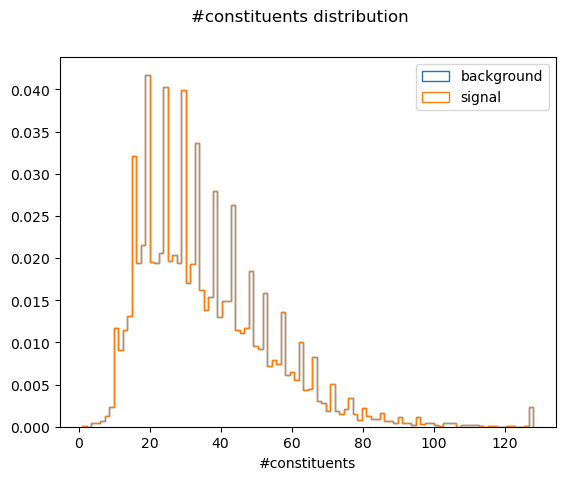

In [14]:
n_bg = np.sum(bg_mask, axis=1)
n_sn = np.sum(bg_mask, axis=1)
fig, ax = plt.subplots()
ax.hist(n_bg, bins=100, histtype='step', color='C0', label='background', density=True)
ax.hist(n_sn, bins=100, histtype='step', color='C1', label='signal', density=True)

ax.legend()
fig.suptitle("#constituents distribution")
ax.set_xlabel("#constituents")

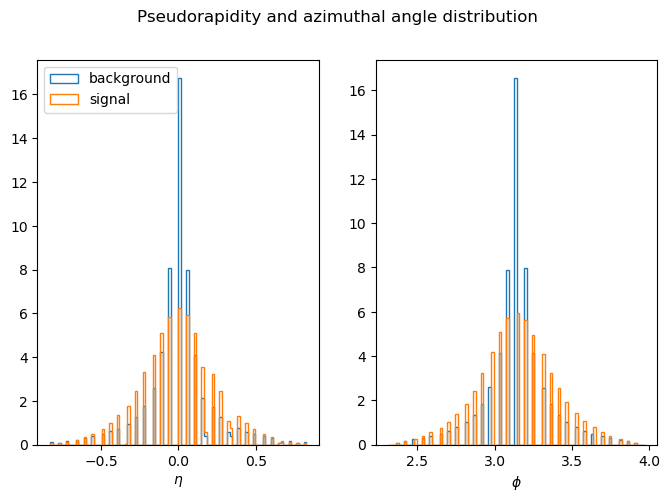

In [17]:
bg_eta, bg_phi = XYZ_to_PtEtaPhi(bg_4mom[bg_mask][:,1], bg_4mom[bg_mask][:,2], bg_4mom[bg_mask][:,3])[1:]
sn_eta, sn_phi = XYZ_to_PtEtaPhi(sn_4mom[sn_mask][:,1], sn_4mom[sn_mask][:,2], sn_4mom[sn_mask][:,3])[1:]

fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].hist(bg_eta, bins=100, histtype='step', color='C0', label='background', density=True)
ax[0].hist(sn_eta, bins=100, histtype='step', color='C1', label='signal', density=True)
ax[1].hist(bg_phi, bins=100, histtype='step', color='C0', label='background', density=True)
ax[1].hist(sn_phi, bins=100, histtype='step', color='C1', label='signal', density=True)
ax[0].legend()
ax[0].set_xlabel("$\eta$")
ax[1].set_xlabel("$\phi$")
fig.suptitle("Pseudorapidity and azimuthal angle distribution");